In [67]:
student_name = 'Mana Abbaszadeh'
student_number = '400109638'

# Bank Marketing Classification

In this part of the assignment we want to do a classification task using PyTorch on bank marketing dataset.

#Import Library

In [68]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from torch.utils.data import DataLoader, TensorDataset

#Load Dataset
Here, you should download and load the dataset. After that, you should split train dataset to train and validation sets. Finally, define the dataloaders for `train`, `validation` and `test`

- %80 training set - %20 val_test --> (%50 validation, %50 test):

In [69]:
#TODO
df = pd.read_csv('bank-full.csv', sep=';')
print(df.head())

label_encoders = {}
categorical_cols = df.select_dtypes(include=['object']).columns
for cols in categorical_cols:
    label_encoders[cols] = LabelEncoder()
    df[cols] = label_encoders[cols].fit_transform(df[cols])

X = df.drop('y', axis=1).values
y = df['y'].values

scaler = StandardScaler()
X = scaler.fit_transform(X)

X_train, X_val_test, y_train, y_val_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_val_test, y_val_test, test_size=0.5, random_state=42)


   age           job  marital  education default  balance housing loan  \
0   58    management  married   tertiary      no     2143     yes   no   
1   44    technician   single  secondary      no       29     yes   no   
2   33  entrepreneur  married  secondary      no        2     yes  yes   
3   47   blue-collar  married    unknown      no     1506     yes   no   
4   33       unknown   single    unknown      no        1      no   no   

   contact  day month  duration  campaign  pdays  previous poutcome   y  
0  unknown    5   may       261         1     -1         0  unknown  no  
1  unknown    5   may       151         1     -1         0  unknown  no  
2  unknown    5   may        76         1     -1         0  unknown  no  
3  unknown    5   may        92         1     -1         0  unknown  no  
4  unknown    5   may       198         1     -1         0  unknown  no  


#Normalize data
normalize numerical data.

In [88]:
# Normalize numerical data

"""
I normalized all the data including numerical in the previous section in this part:


label_encoders = {}
categorical_columns = df.select_dtypes(include=['object']).columns
for column in categorical_columns:
    label_encoders[column] = LabelEncoder()
    df[column] = label_encoders[column].fit_transform(df[column])

X = df.drop('y', axis=1).values
y = df['y'].values

scaler = StandardScaler()
X = scaler.fit_transform(X)


After this I splitted the data into test, validation and training set. So I won't do this here again!

"""

"\nI normalized all the data including numerical in the previous section in this part:\n\n\nlabel_encoders = {}\ncategorical_columns = df.select_dtypes(include=['object']).columns\nfor column in categorical_columns:\n    label_encoders[column] = LabelEncoder()\n    df[column] = label_encoders[column].fit_transform(df[column])\n\nX = df.drop('y', axis=1).values\ny = df['y'].values\n\nscaler = StandardScaler()\nX = scaler.fit_transform(X)\n\n\nAfter this I splitted the data into test, validation and training set. So I won't do this here again!\n\n"

# Create Data Loader
create data loader for pytorch

In [71]:
#TODO
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.long)


tensor_train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
tensor_val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
tensor_test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(tensor_train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(tensor_val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(tensor_test_dataset, batch_size=32, shuffle=False)

print('Setting data was successful!')

Setting data was successful!


#Model
define your model in here

In [82]:
class BankMarketingNet(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_dim):
        super(BankMarketingNet, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_dim, output_dim)
        pass


    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        return out
        pass

In [83]:
input_dim = X_train.shape[1]
output_dim = 2
hidden_dim = 64
model = BankMarketingNet(input_dim, output_dim, hidden_dim)

#Train your model
Define `criterion` and `optimizer`.
Train your model

Tasks:
- [ ] Things that are needed to be printed in each epoch:
  - Number of epoch
  - Train loss
  - Validation loss
- [ ] save train/validation loss (of each epoch) in an array for later usage

In [85]:
#TODO
cross_entropy_loss = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 20
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    bar = tqdm(enumerate(train_loader), total=len(train_loader))
    for idx, (ins, labels) in bar:
        optimizer.zero_grad()
        out = model(ins)
        loss = cross_entropy_loss(out, labels)
        loss.backward()
        optimizer.step()
        running_loss += ins.size(0) * loss.item()
        bar.set_description(f'Epoch {epoch + 1}/{num_epochs}, Loss: {loss.item():.4f}')
    
    total_len = len(train_loader.dataset)
    epoch_loss = running_loss / total_len
    train_losses.append(epoch_loss)

    
    model.eval()
    total = 0
    correct = 0
    validation_loss = 0.0
    with torch.no_grad():
        for ins, labels in val_loader:
            out = model(ins)
            loss = cross_entropy_loss(out, labels)
            validation_loss += ins.size(0) * loss.item()
            i , pred = torch.max(out, 1)
            total += labels.size(0)
            correct += (pred == labels).sum().item()
    
    total_len = len(val_loader.dataset)
    validation_loss = validation_loss / total_len
    val_losses.append(validation_loss)
    
    print(f'Train_Loss: {epoch_loss:.4f}, Validation_Loss: {validation_loss:.4f}')


Epoch 1/20, Loss: 0.3328: 100%|██████████| 1131/1131 [00:04<00:00, 234.81it/s]


Train_Loss: 0.2214, Validation_Loss: 0.2351


Epoch 2/20, Loss: 0.1047: 100%|██████████| 1131/1131 [00:04<00:00, 241.48it/s]


Train_Loss: 0.2207, Validation_Loss: 0.2342


Epoch 3/20, Loss: 0.0719: 100%|██████████| 1131/1131 [00:04<00:00, 242.43it/s]


Train_Loss: 0.2203, Validation_Loss: 0.2328


Epoch 4/20, Loss: 0.3896: 100%|██████████| 1131/1131 [00:04<00:00, 234.60it/s]


Train_Loss: 0.2200, Validation_Loss: 0.2333


Epoch 5/20, Loss: 0.5410: 100%|██████████| 1131/1131 [00:04<00:00, 226.99it/s]


Train_Loss: 0.2190, Validation_Loss: 0.2352


Epoch 6/20, Loss: 0.0721: 100%|██████████| 1131/1131 [00:04<00:00, 244.99it/s]


Train_Loss: 0.2187, Validation_Loss: 0.2333


Epoch 7/20, Loss: 0.4239: 100%|██████████| 1131/1131 [00:04<00:00, 239.32it/s]


Train_Loss: 0.2182, Validation_Loss: 0.2349


Epoch 8/20, Loss: 0.0608: 100%|██████████| 1131/1131 [00:04<00:00, 234.56it/s]


Train_Loss: 0.2175, Validation_Loss: 0.2330


Epoch 9/20, Loss: 0.2898: 100%|██████████| 1131/1131 [00:04<00:00, 236.05it/s]


Train_Loss: 0.2174, Validation_Loss: 0.2339


Epoch 10/20, Loss: 0.2474: 100%|██████████| 1131/1131 [00:04<00:00, 242.33it/s]


Train_Loss: 0.2167, Validation_Loss: 0.2338


Epoch 11/20, Loss: 0.1376: 100%|██████████| 1131/1131 [00:04<00:00, 234.56it/s]


Train_Loss: 0.2160, Validation_Loss: 0.2331


Epoch 12/20, Loss: 0.0573: 100%|██████████| 1131/1131 [00:04<00:00, 237.08it/s]


Train_Loss: 0.2157, Validation_Loss: 0.2347


Epoch 13/20, Loss: 0.1800: 100%|██████████| 1131/1131 [00:04<00:00, 236.19it/s]


Train_Loss: 0.2152, Validation_Loss: 0.2333


Epoch 14/20, Loss: 0.0762: 100%|██████████| 1131/1131 [00:04<00:00, 253.43it/s]


Train_Loss: 0.2147, Validation_Loss: 0.2351


Epoch 15/20, Loss: 0.0957: 100%|██████████| 1131/1131 [00:04<00:00, 253.99it/s]


Train_Loss: 0.2144, Validation_Loss: 0.2359


Epoch 16/20, Loss: 0.1996: 100%|██████████| 1131/1131 [00:04<00:00, 254.06it/s]


Train_Loss: 0.2141, Validation_Loss: 0.2328


Epoch 17/20, Loss: 0.2531: 100%|██████████| 1131/1131 [00:04<00:00, 258.69it/s]


Train_Loss: 0.2142, Validation_Loss: 0.2327


Epoch 18/20, Loss: 0.1288: 100%|██████████| 1131/1131 [00:04<00:00, 250.59it/s]


Train_Loss: 0.2135, Validation_Loss: 0.2349


Epoch 19/20, Loss: 0.4640: 100%|██████████| 1131/1131 [00:04<00:00, 249.60it/s]


Train_Loss: 0.2134, Validation_Loss: 0.2373


Epoch 20/20, Loss: 0.1006: 100%|██████████| 1131/1131 [00:04<00:00, 242.70it/s]


Train_Loss: 0.2129, Validation_Loss: 0.2348


### Visualize Loss plot

Using the arrays that you have (from previous task in the above section), visualize Loss plot (train and validation together)

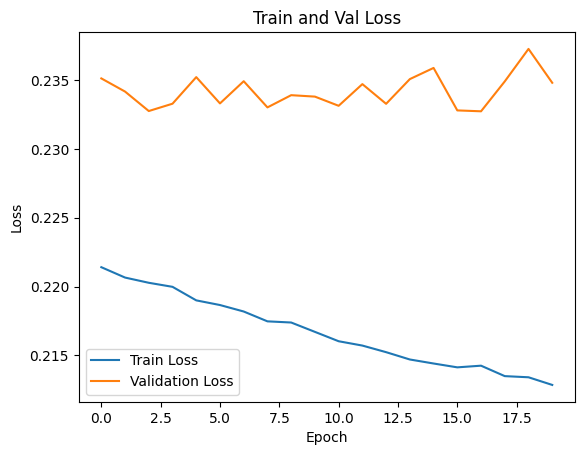

In [86]:
#TODO
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train and Val Loss')
plt.legend()
plt.show()

## Evaluation

Test your trained model (using the Test Dataloader that you have).

In [87]:
#TODO
model.eval()
total = 0
correct = 0
test_loss = 0.0

with torch.no_grad():
    for ins, labels in test_loader:
        out = model(ins)
        loss = cross_entropy_loss(out, labels)
        test_loss += ins.size(0) * loss.item()
        i, pred = torch.max(out, 1)
        total += labels.size(0)
        correct += (pred == labels).sum().item()

total_len = len(test_loader.dataset)
test_loss = test_loss / total_len
test_accuracy = correct / total

print(f'Test Loss: {test_loss:}')
print(f'Accuracy: {test_accuracy * 100:}%')


Test Loss: 0.2353342978999658
Accuracy: 89.80539584254754%
